In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import os
os.getcwd()
os.chdir("/nfs/pic.es/user/m/mbilkis/qmon-sindy")
from numerics.utilities.misc import *
import matplotlib.pyplot as plt 
from numerics.NN.models.sindy_osc_exp_dec import *
from numerics.NN.misc import * 
import torch
import numpy as np
from scipy.linalg import solve_continuous_are
from tqdm import tqdm

In [5]:
mode="osc-exp-dec"
x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
####
params, exp_path = give_params(mode=mode)
gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
period = (2*np.pi/omega)
total_time = period*periods
dt = period/ppp
times = np.arange(0,total_time+dt,dt)
###

torch.manual_seed(0)


K0 = [-.01,.01]

gf = .1
wf=.7
K1 = np.array([[-gf,wf],[-wf,-gf]])

K2_0 = K2_1 = 0.1*K1

inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [[200.,0], K0, K1, K2_0,K2_1  ]]
dev = torch.device("cpu")
rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
ixs_hat, idys_hat, ifs_hats = rrn(dys)


In [10]:

save_dir = "results/osc_exp_dec_sindy_0_1_2_/regularizers/"
os.makedirs(save_dir,exist_ok=True)



In [ ]:
alpha = alphas[0]
alpha

In [ ]:
history = load_history(what="osc-dec-sindy/regularizers/{}".format(alpha), exp_path=exp_path,itraj=1)
best_ind = set_params_to_best(rrn,history)
xs_hat, dys_hat, fs_hats = rrn(dys)

In [ ]:
history["losses"][-1]

In [ ]:
alphas = list(np.linspace(1e-6, 1., 20))

for itraj in range(1,20):
    print(itraj)
    try:
        mode="osc-exp-dec"
        x = load_data(itraj=itraj, what="hidden_state.npy",mode=mode)
        dy = load_data(itraj=itraj,what="dys.npy",mode=mode)
        f = load_data(itraj=itraj, what="external_signal.npy",mode=mode)
        ####
        params, exp_path = give_params(mode=mode)
        gamma, omega, n, eta, kappa, params_force, [periods, ppp] = params
        period = (2*np.pi/omega)
        total_time = period*periods
        dt = period/ppp
        times = np.arange(0,total_time+dt,dt)
        ###

        torch.manual_seed(0)


        K0 = [-.01,.01]

        gf = .1
        wf=.7
        K1 = np.array([[-gf,wf],[-wf,-gf]])

        K2_0 = K2_1 = 0.1*K1

        inputs_cell = [dt,  [gamma, omega, n, eta, kappa, params_force], [[200.,0], K0, K1, K2_0,K2_1  ]]
        dev = torch.device("cpu")
        rrn = RecurrentNetwork(inputs_cell)

        optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

        dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
        ixs_hat, idys_hat, ifs_hats = rrn(dys)

        save_dir = "results/osc_exp_dec_sindy_0_1_2_/regularizers/"
        os.makedirs(save_dir,exist_ok=True)

        plt.figure(figsize=(25,3))
        ax=plt.subplot(171)
        ax.plot(ixs_hat.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(x[:,0])
        ax=plt.subplot(172)
        ax.plot(ixs_hat.detach().numpy()[:,1], color="red",marker='.')
        ax.plot(x[:,1])
        ax=plt.subplot(173)
        ax.plot(dys[:,0])
        ax.plot(idys_hat.detach().numpy()[:,0], color="red",marker='.')

        ax=plt.subplot(174)
        ax.plot(ifs_hats.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(f[:,0])
        plt.savefig(save_dir+"untrained_{}.png".format(itraj))

        alpha = alphas[itraj]
        history = load_history(what="osc-dec-sindy/regularizers/{}".format(alpha), exp_path=exp_path,itraj=itraj)
        best_ind = set_params_to_best(rrn,history)
        xs_hat, dys_hat, fs_hats = rrn(dys)

        ll = np.stack(history["losses"])
        plt.figure(figsize=(25,3))
        ax=plt.subplot(171)
        ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(x[:,0])
        ax=plt.subplot(172)
        ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
        ax.plot(x[:,1])
        ax=plt.subplot(173)
        ax.plot(dys[:,0])
        ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

        ax=plt.subplot(174)
        ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
        ax.plot(f[:,0])

        ax=plt.subplot(175)
        ax.plot(ll[:,0], color="blue")
        ax.set_ylabel("normalized likelihood")
        ax.tick_params(axis='y', labelcolor="blue")
        ax = ax.twinx()
        ax.plot(ll[:,1], color="red")
        ax.tick_params(axis='y', labelcolor="red")
        ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)
        plt.savefig(save_dir+"trained_{}.png".format(itraj))
    except Exception:
        print("err",itraj)
        pass

In [ ]:
loss

/nfs/pic.es/user/m/mbilkis/qmon-sindy/numerics/NN/misc.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  k.data = torch.tensor(j)


In [26]:
list(rrn.parameters())

[Parameter containing:
 tensor([199.4303,   4.4193], requires_grad=True),
 Parameter containing:
 tensor([10.5311, -1.0628], requires_grad=True),
 Parameter containing:
 tensor([[-2.0018,  0.5142],
         [-1.4365, -0.4537]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0081, -0.1266],
         [ 0.0032, -0.0424]], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0015,  0.0815],
         [-0.0086,  0.0514]], requires_grad=True)]

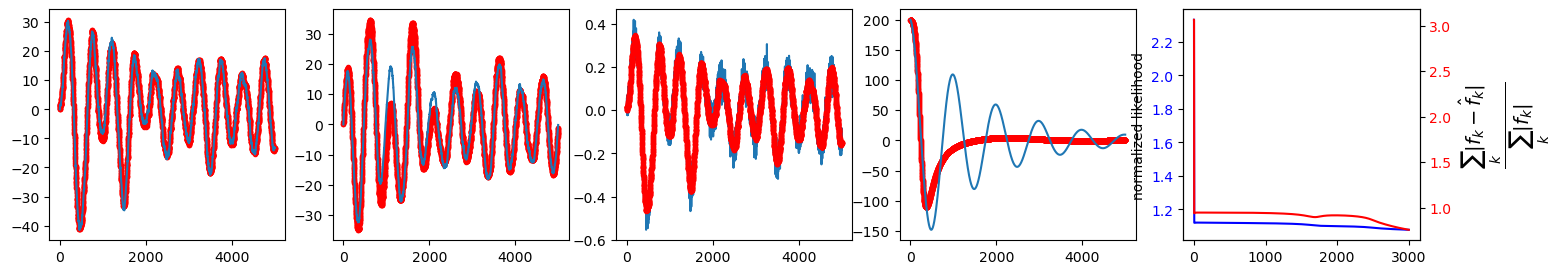

In [23]:
history["optimizer"]

KeyError: 'optimizer'

In [21]:
Ahist = np.squeeze(np.stack([history["params"][k][1] for k in range(len(history["params"]))]))
f0 = np.squeeze(np.stack([history["params"][k][0] for k in range(len(history["params"]))]))
b=params_force
true_gamma = b[1][0]
true_omega = b[1][1]
true_f0 = b[0][0]
true_f0_dot = b[0][1]
Atrue = np.array([[true_gamma, true_omega],[-true_omega, true_gamma]] )


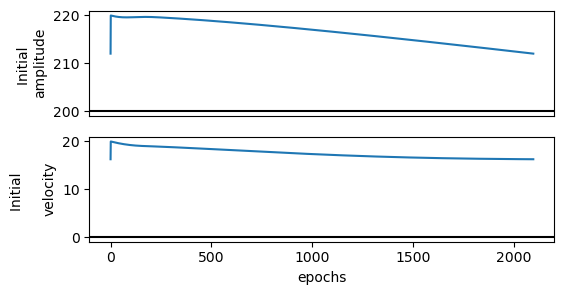

In [36]:
fig=plt.figure(figsize=(6,3))
ax=plt.subplot(211)
ax.plot(f0[:,0])
ax.set_ylabel("Initial \namplitude")
ax.set_xticks([])
ax.axhline(true_f0,color="black")
ax=plt.subplot(212)
ax.plot(f0[:,1])
ax.set_ylabel("Initial \n \nvelocity")
ax.axhline(true_f0_dot,color="black")
ax.set_xlabel("epochs")
plt.savefig(save_dir+"evolution_f0.pdf")

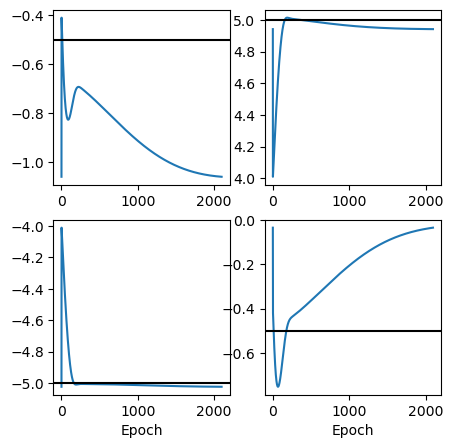

In [35]:
plt.figure(figsize=(5,5))
plt.tight_layout()
posis=[221,222,223,224]
k=0
for i in range(2):
    for j in range(2):
        ax=plt.subplot(posis[k])
        ax.plot(Ahist[:,i,j], label="pred")
        ax.axhline(Atrue[i,j],color="black")
        if k in [0,1]:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Epoch")            
        k+=1
plt.savefig(save_dir+"evolution_params.pdf")

In [30]:
history["losses"][best_ind]

[1.0093046426773071, 0.0775080375363841]

In [25]:
Ahist[best_ind]

array([[-1.0594219 ,  4.941394  ],
       [-5.024772  , -0.03439875]], dtype=float32)

In [26]:
Atrue

array([[-0.5,  5. ],
       [-5. , -0.5]])

In [27]:
f0[best_ind]

array([212.00351 ,  16.273136], dtype=float32)

In [29]:
[true_f0,true_f0_dot]

[200.0, 0.0]

In [23]:
best_params = []
for itraj in tqdm(range(1000)):
    try:
        history = load_history(what="exp_dec_2_params", exp_path=exp_path,itraj=itraj)
        index_favorite = np.argmin(np.array(history["losses"])[:,0])
        news = history["params"][index_favorite]
        best_params.append(news)
    except Exception:
        pass


100%|██████████| 1000/1000 [03:37<00:00,  4.60it/s]


In [24]:
len(best_params)

491

In [37]:
gf = 1.0
af = 200

fisher_AF = (4*eta*kappa/gamma)*(1-np.exp(-gf*times[-1]))**2

In [40]:
np.mean(np.array([best_params[k][0] for k in range(len(best_params))])- af)**2

360.91462449416576

In [44]:
np.std(np.array([best_params[k][0] for k in range(len(best_params))]))**2

124.25038576962925

In [41]:
1/fisher_AF

0.00376404515100404

In [43]:
kappa/gamma

66.66666666666667

In [171]:
torch.manual_seed(0)

dev = torch.device("cpu")

gf = .1
wf=.7
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [[200.,0], [[-gf,wf],[-wf,-gf]]  ]]

rrn = RecurrentNetwork(inputs_cell)

optimizer = torch.optim.Adam(list(rrn.parameters()), lr=1e-2)

dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))

xs_hat, dys_hat, fs_hats = rrn(dys)
loss = log_lik(dys, dys_hat)
history = {}
history["losses"] = [ [loss.item(),err_f(f[:,0],fs_hats[:,0])]  ]
history["params"] = [[k.detach().data for k in list(rrn.parameters())]]
history["gradients"] = []

In [167]:
printing=True

In [173]:
ll = np.stack(history["losses"])

In [198]:
torch.manual_seed(0)
gf = .1
wf=.7
inputs_cell = [dt,  [gamma, omega, n, eta, kappa, b], [[200.,0], [[-gf,wf],[-wf,-gf]]  ]]
irrn = RecurrentNetwork(inputs_cell)
dys = torch.tensor(data=dy, dtype=torch.float32).to(torch.device("cpu"))
ixs_hat, idys_hat, ifs_hats = irrn(dys)


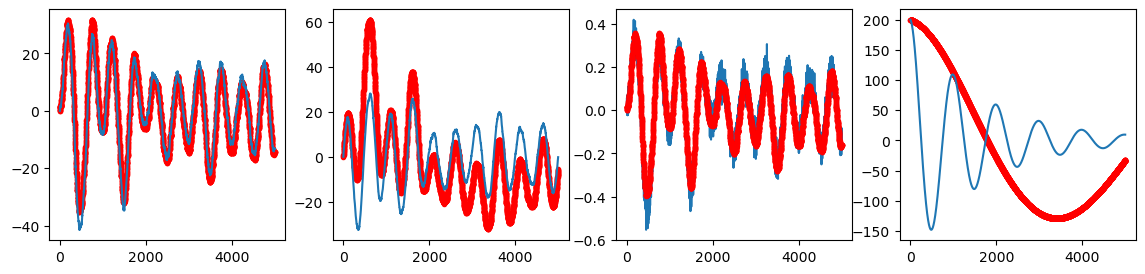

In [199]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(ixs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(ixs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(idys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(ifs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])


Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

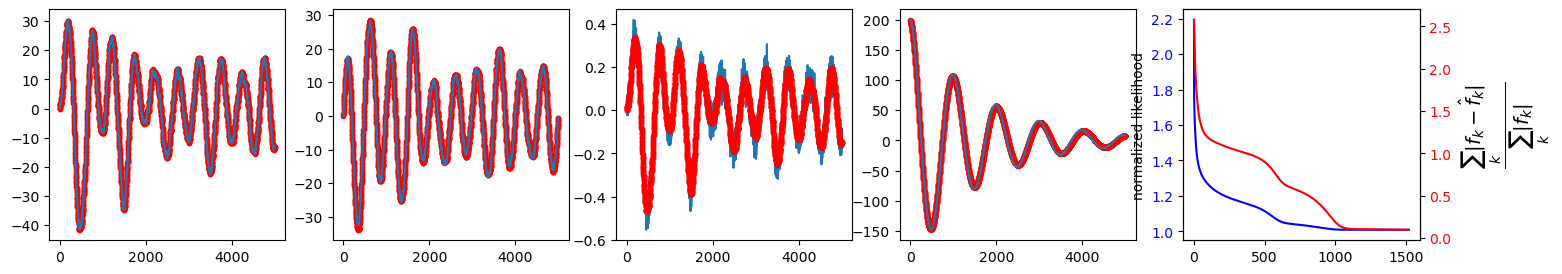

In [175]:
plt.figure(figsize=(25,3))
ax=plt.subplot(171)
ax.plot(xs_hat.detach().numpy()[:,0], color="red",marker='.')
ax.plot(x[:,0])
ax=plt.subplot(172)
ax.plot(xs_hat.detach().numpy()[:,1], color="red",marker='.')
ax.plot(x[:,1])
ax=plt.subplot(173)
ax.plot(dys[:,0])
ax.plot(dys_hat.detach().numpy()[:,0], color="red",marker='.')

ax=plt.subplot(174)
ax.plot(fs_hats.detach().numpy()[:,0], color="red",marker='.')
ax.plot(f[:,0])

ax=plt.subplot(175)
ax.plot(ll[:,0], color="blue")
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

In [188]:
Ahist = np.squeeze(np.stack([history["params"][k][1] for k in range(len(history["params"]))]))
f0 = np.squeeze(np.stack([history["params"][k][0] for k in range(len(history["params"]))]))
true_gamma = b[1][0]
true_omega = b[1][1]
true_f0 = b[0][0]
true_f0_dot = b[0][1]

In [195]:
Ahist[-1]

array([[-0.90564907,  4.9382286 ],
       [-4.9314656 , -0.12887985]], dtype=float32)

In [206]:
Ahist = np.squeeze(np.stack([history["params"][k][1] for k in range(len(history["params"]))]))
f0 = np.squeeze(np.stack([history["params"][k][0] for k in range(len(history["params"]))]))
true_gamma = b[1][0]
true_omega = b[1][1]
true_f0 = b[0][0]
true_f0_dot = b[0][1]
Atrue = np.array([[true_gamma, true_omega],[-true_omega, true_gamma]] )


In [202]:
Atrue

[[-0.5, 5.0], [-5.0, -0.5]]

Text(0.5, 0, 'epochs')

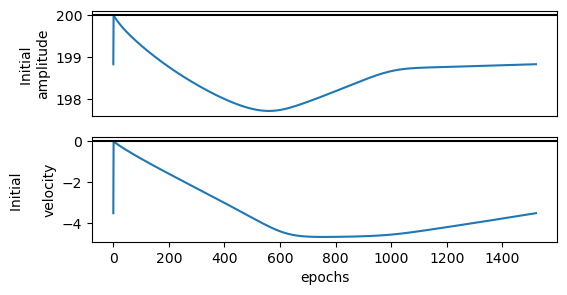

In [220]:
fig=plt.figure(figsize=(6,3))
ax=plt.subplot(211)
ax.plot(f0[:,0])
ax.set_ylabel("Initial \namplitude")
ax.set_xticks([])
ax.axhline(true_f0,color="black")
ax=plt.subplot(212)
ax.plot(f0[:,1])
ax.set_ylabel("Initial \n \nvelocity")
ax.axhline(true_f0_dot,color="black")
ax.set_xlabel("epochs")

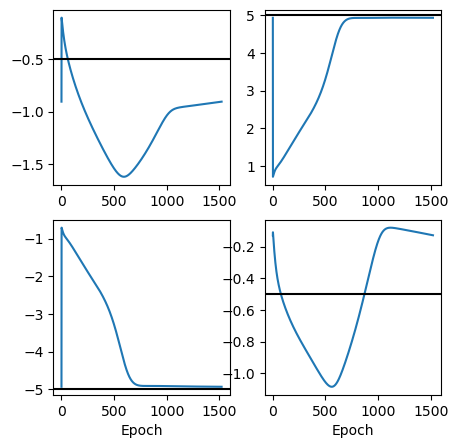

In [214]:
plt.figure(figsize=(5,5))
plt.tight_layout()
posis=[221,222,223,224]
k=0
for i in range(2):
    for j in range(2):
        ax=plt.subplot(posis[k])
        ax.plot(Ahist[:,i,j], label="pred")
        ax.axhline(Atrue[i,j],color="black")
        if k in [0,1]:
            ax.set_xlabel("")
        else:
            ax.set_xlabel("Epoch")            
        k+=1


In [182]:
np.squeeze(Ahist).shape

(1522, 2, 2)

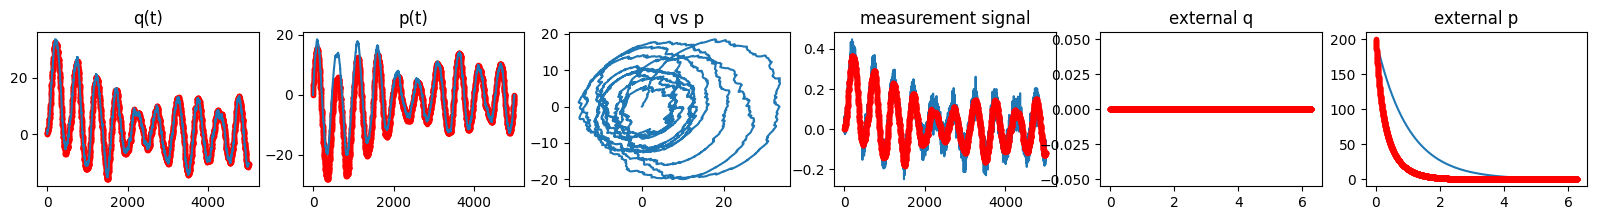


# Training

In [14]:
def log_lik(dys, dys_hat):
    return torch.sum((dys-dys_hat)**2)/(dt*len(dys))

def err_f(f,fhat):
    return np.sum(np.abs(f - fhat[:-1,:].detach().numpy() ))/np.sum(np.abs(f))

In [21]:
ll = np.stack(history["losses"])

Text(0, 0.5, '$\\frac{\\sum_k |f_k - \\hat{f}_k|}{\\sum_k |f_k|}$')

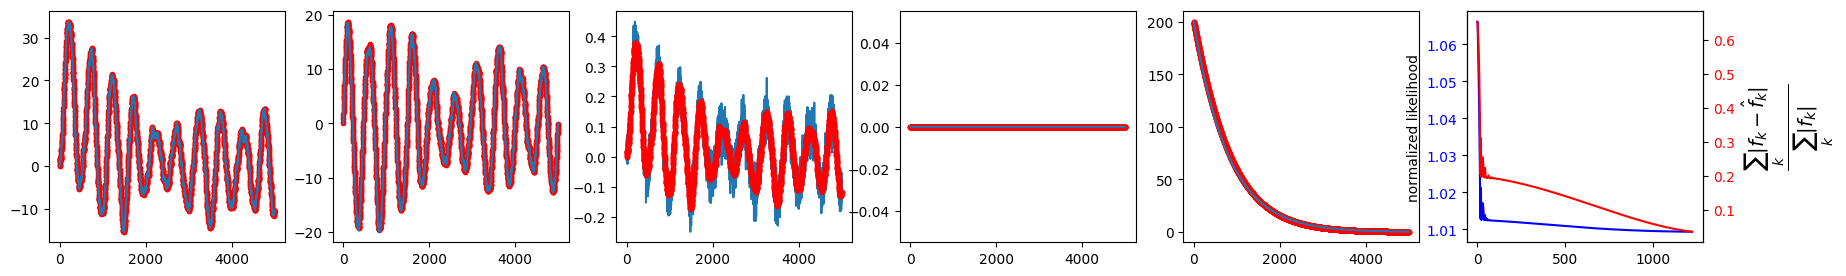

In [37]:
history["params"][4]

[array(1.6777, dtype=float32),
 array(-0.00103082, dtype=float32),
 array([0.64584786, 0.9788142 ], dtype=float32)]

In [38]:
[history["params"][k][0] for k in range(3,len(history["params"])-1)]

[array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1.6777, dtype=float32),
 array(1

In [22]:
import pickle
itraj = 1
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/DERIVATIVE_only_gamma/"
os.makedirs(path,exist_ok=True)

with open(path+"history.pickle", "wb") as output_file:
   pickle.dump(history, output_file)

In [35]:
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/PROFILE_only_gamma/"
with open(path+"history.pickle", "rb") as output_file:
   aa = pickle.load(output_file)
hsitory_prof = aa

In [25]:
path = get_def_path()+ exp_path + "{}itraj/T_{}_dt_{}/".format(itraj, total_time, dt)+"/EXPONENTIALLY_DEC/DERIVATIVE_only_gamma/"

os.makedirs(path,exist_ok=True)

with open(path+"history.pickle", "wb") as output_file:
   pickle.dump(history, output_file)


with open(path+"history.pickle", "rb") as output_file:
   aa = pickle.load(output_file)

history_der = aa

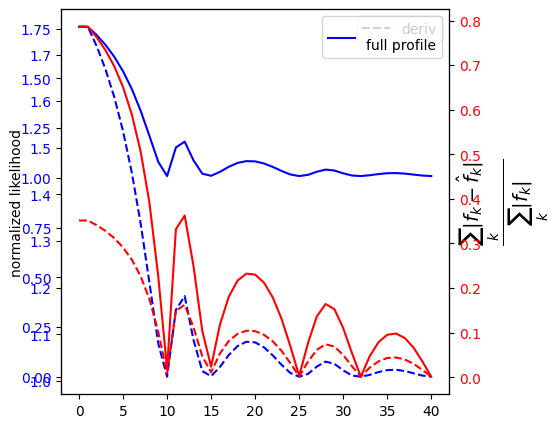

In [41]:
plt.figure(figsize=(5,5))
ax=plt.subplot()
ll = np.stack(history_der["losses"])
ax.plot(ll[:,0], '--',color="blue",label="deriv")
ax.legend()
ax.set_ylabel("normalized likelihood")
ax.tick_params(axis='y', labelcolor="blue")
ax = ax.twinx()
ax.plot(ll[:,1], '--', color="red")
ax.tick_params(axis='y', labelcolor="red")
ax.set_ylabel(r'$\frac{\sum_k |f_k - \hat{f}_k|}{\sum_k |f_k|}$',size=20)

ll = np.stack(hsitory_prof["losses"])
ax.plot(ll[:,0], color="blue",  label="\nfull profile")
ax.tick_params(axis='y', labelcolor="blue")

ax.legend()
ax = ax.twinx()
ax.plot(ll[:,1], color="red")
ax.tick_params(axis='y', labelcolor="red")


### Let's check now the amplitude!

In [125]:
xs_hat.shape

torch.Size([5002, 6])

In [131]:
[history["params"][k] for k in range(3,len(params))]

[[array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)],
 [array(0.7952589, dtype=float32),
  array(1.7952825, dtype=float32),
  array([0.7952589, 0.7942535], dtype=float32)]]

In [122]:
ll={}
for j in range(len(history["params"][0])):
    l[j] = [history["params"][k][j] for k in len(history["params"])]

TypeError: len() of unsized object

In [118]:
history["params"]

[array(nan, dtype=float32),
 array(nan, dtype=float32),
 array([nan, nan], dtype=float32),
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float32),
  array([nan, nan], dtype=float32)],
 [array(nan, dtype=float32),
  array(nan, dtype=float3